In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import torch

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

In [2]:
df = pd.read_csv('../data/dataset/esol.csv')

In [14]:
df.columns

Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')

In [24]:
(df.sort_values(by=['Molecular Weight'])[200:220])

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
612,"2,4-Dimethylpyridine",-2.098,1,107.156,0,1,0,12.89,0.380,Cc1ccnc(C)c1
241,m-Methylaniline,-1.954,1,107.156,1,1,0,26.02,-0.850,Cc1cccc(N)c1
385,p-Methylaniline,-1.954,1,107.156,1,1,0,26.02,-1.210,Cc1ccc(N)cc1
130,"3,4-Dimethylpyridine",-2.067,1,107.156,0,1,0,12.89,0.360,Cc1ccncc1C
141,"2,6-Dimethylpyridine",-2.098,1,107.156,0,1,0,12.89,0.450,Cc1cccc(C)n1
693,Anisole,-2.368,1,108.140,0,1,1,9.23,-1.850,COc1ccccc1
487,Phenylmethanol,-1.699,1,108.140,1,1,1,20.23,-0.400,OCc1ccccc1
999,p-Cresol,-2.313,1,108.140,1,1,0,20.23,-0.730,Cc1ccc(O)cc1
342,3-Methylphenol,-2.313,1,108.140,1,1,0,20.23,-0.680,Cc1cccc(O)c1
55,2-Methylphenol,-2.281,1,108.140,1,1,0,20.23,-0.620,Cc1ccccc1O


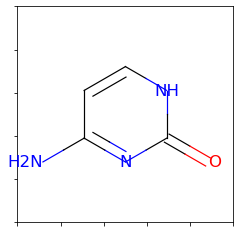

In [26]:
smiles = df['smiles']
m = Chem.MolFromSmiles(smiles.iloc[669])
fig = Draw.MolToMPL(m, size=(120, 120))

In [15]:
all_atom_names = []
all_hydrogens = []

for i, smile in enumerate(smiles):
    m = Chem.MolFromSmiles(smile)
    atom_names = [a.GetSymbol() for a in m.GetAtoms()]
    hydrogens = [a.GetImplicitValence() for a in m.GetAtoms()]
    all_atom_names += atom_names
    all_hydrogens += hydrogens
    
atom_dict = {}
for i, a in enumerate(list(Counter(all_atom_names))):
    atom_dict[a] = i
    
max_hydrogen = max(Counter(all_hydrogens).keys())

4


In [25]:
node_data = []
adj_data = []
target_data = []

expt = df['expt']

for i, smile in enumerate(smiles):
    m = Chem.MolFromSmiles(smile)
    atom_names = [a.GetSymbol() for a in m.GetAtoms()]
    hydrogen_nums = [a.GetImplicitValence() for a in m.GetAtoms()]
    
    node = []
    for j, (a, h) in enumerate(zip(atom_names, hydrogen_nums)):
        node_atom_names = np.zeros(len(atom_dict))
        node_hydrogens = np.zeros(max_hydrogen+1)
        
        node_atom_names[atom_dict[a]] += 1
        node_hydrogens[h] += 1
        node.append(node_atom_names)
    node = np.array(node)
        
    adj = GetAdjacencyMatrix(m)
    
    node_data.append(torch.from_numpy(node).float())
    adj_data.append(torch.from_numpy(adj + np.eye(len(adj))).float())
    target_data.append(torch.FloatTensor([expt[i]]))

In [26]:
dataset = []
dataset.append(node_data)
dataset.append(adj_data)
dataset.append(target_data)

In [27]:
torch.save(dataset, '../dataset/freesolv.pt')